In [1]:
# pip install pandas scikit-learn matplotlib

In [2]:
from pathlib import Path
import os

import utils as u

In [3]:
notebook_path = Path(os.path.abspath("."))
data_path = notebook_path.parent / "docs" / "data"

# EVALUATION

## NHL

In [4]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nhl", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=6.5, hcp_line=1.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,2025020522,2025-12-17T00:00:00,Detroit Red Wings,New York Islanders,0.5460,0.4406,0.7686,3,2,True,False,True
1,2025020338,2025-11-23T00:00:00,Florida Panthers,Edmonton Oilers,0.5131,0.4313,0.7395,3,6,False,True,False


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          697      0.5294 0.2536   0.7009 0.5222   0.5222
Totals (Over/Under)  697      0.4735 0.2498   0.6926 0.5217   0.5237
Asian Handicap       697      0.7461 0.1897   0.5665 0.5634   0.7432


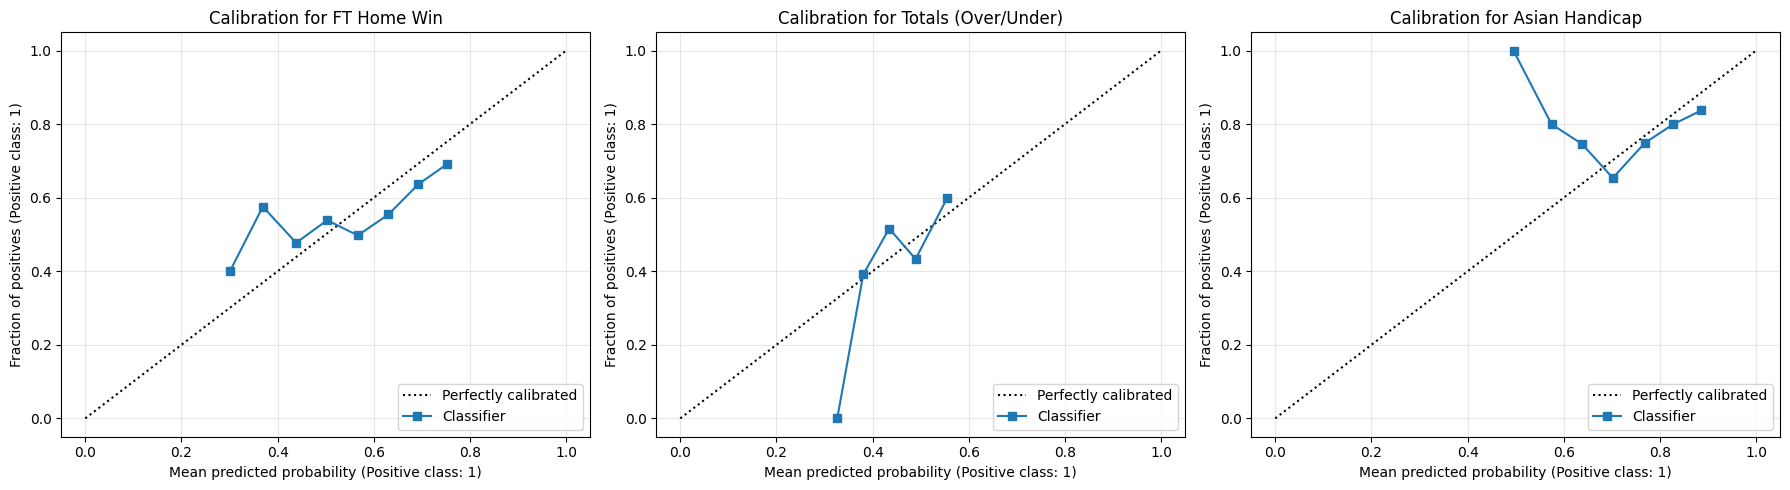

In [5]:
# Evaluate everything
_ = u.evaluate_calibration(df=df, n_bins=15)

=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          557      0.5296 0.2520   0.6972 0.5324   0.5224
Totals (Over/Under)  557      0.4740 0.2496   0.6923 0.5274   0.5153
Asian Handicap       557      0.7433 0.1910   0.5683 0.5670   0.7397


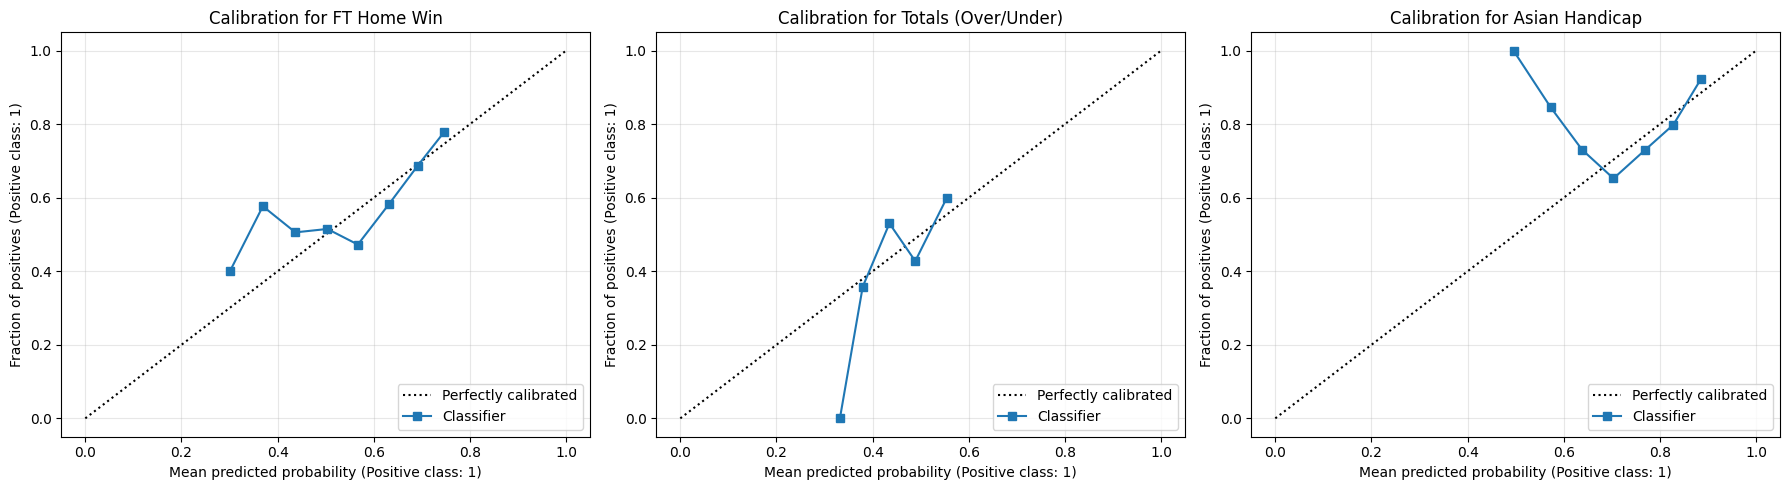

In [6]:
# Evaluate matches only after major bugfix
after_bug_df = df[df["start_time_utc"]>="2025-10-29 15:00:00"].copy()
_ = u.evaluate_calibration(df=after_bug_df, n_bins=15)

## NBA

In [7]:
prediction_files, results_files = u.get_prediction_results_filepaths(league="nba", root=data_path)

df = u.make_dataframe(pred_filepaths=prediction_files, res_filepaths=results_files, total_line=225.5, hcp_line=8.5)
df.head(2)

,match_id,start_time_utc,home_team,away_team,ft_home_prob,ou_prob,hcp_prob,home_team_score,away_team_score,ft_home_won,ou_won,hcp_won
0,0022500264,2025-11-21T00:00:00,Orlando Magic,Los Angeles Clippers,0.3465,0.3498,0.5706,129,101,True,True,True
1,0022500570,2026-01-14T04:00:00,Golden State Warriors,Portland Trailblazers,0.6272,0.5922,0.8119,119,97,True,False,True


=== Evaluation Summary ===
                       n  prevalence  brier  logloss    auc  acc@0.5
metric                                                              
FT Home Win          403      0.5583 0.2346   0.6643 0.6464   0.6154
Totals (Over/Under)  403      0.5782 0.2500   0.6992 0.5978   0.5757
Asian Handicap       403      0.7568 0.1748   0.5264 0.6720   0.7469


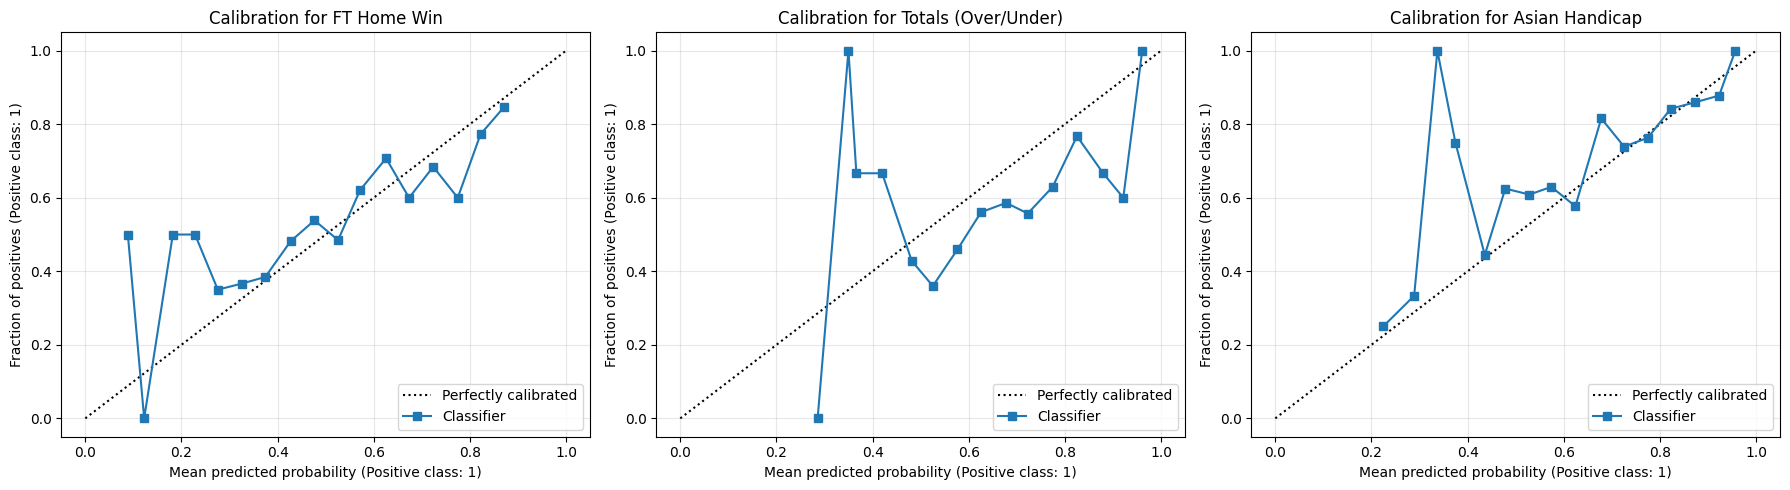

In [8]:
_ = u.evaluate_calibration(df=df, n_bins=20)